In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import time
import pandas as pd

/home/luqman/.local/share/virtualenvs/ME-GraphAU-NHAhuV8b/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert video to frames

In [29]:
start_time = time.time()
video_dir = "/nas/database/Big5/train"
output_dir = "/nas/project_data/B1_Behavior/hakim/FI/frames/train"
annotation_path = '/nas/database/Big5/gt/annotation_training.pkl'
with open(annotation_path, 'rb') as f:
    annotation = pickle.load(f, encoding='latin1')
video_names = list(annotation['extraversion'].keys())

for video_name in video_names:
    print(f'Processing {video_name}')
    dir_name = video_name.rsplit(".")[0] + "." + video_name.rsplit(".")[1] 
    out_path = os.path.join(output_dir, dir_name)
    os.makedirs(out_path, exist_ok=True)
    video_path = os.path.join(video_dir, video_name)
    command = "/home/luqman/ffmpeg/ffmpeg-git-20220622-amd64-static/ffmpeg -loglevel warning -t 15 -i " + video_path + " -r:v 30 -frames:v 450 " + os.path.join(out_path, "%d.png") 
    os.system(command)
    break
    
print("--- %s seconds ---" % (time.time() - start_time))

Processing J4GQm9j0JZ0.003.mp4
--- 2.375793218612671 seconds ---


# MTCNN

In [20]:
start_time = time.time()
input_dir = '/nas/project_data/B1_Behavior/hakim/FI/frames/train'
output_dir = '/nas/project_data/B1_Behavior/hakim/FI/mtcnn'
annotation_path = '/nas/database/Big5/gt/annotation_training.pkl'
batch_size = 32
mtcnn = MTCNN(keep_all=True, device='cuda:0')
with open(annotation_path, 'rb') as f:
    annotation = pickle.load(f, encoding='latin1')
video_names = list(annotation['extraversion'].keys())

for video_name in video_names:
    print(f'Processing {video_name}')
    frames = []
    boxes = []
    landmarks = []
    probs = []
    dir_name = video_name.rsplit(".")[0] + "." + video_name.rsplit(".")[1]
    img_dir = os.path.join(input_dir, dir_name)
    file_count = len([x for x in os.listdir(img_dir)])
    
    for i in range(1, file_count+1):
        filename = str(i) + '.png'
        img_path = os.path.join(img_dir, filename)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(img)
        frames.append(frame)

        if (len(frames) == batch_size or i == file_count):
            batch_boxes, batch_probs, batch_landmarks = mtcnn.detect(frames, landmarks=True)
            boxes.extend(batch_boxes)
            landmarks.extend(batch_landmarks)
            probs.extend(batch_probs)
            frames = []

    output = {'boxes': boxes, 'probs': probs, 'landmarks': landmarks}
    out_filename = dir_name + ".pickle"
    out_path = os.path.join(output_dir, out_filename)
    outfile = open(out_path, 'wb')
    pickle.dump(output, outfile)
    outfile.close()
    print(f'Output is saved on {out_path}')
    break

print("--- %s seconds ---" % (time.time() - start_time))

Processing J4GQm9j0JZ0.003.mp4
Output is saved on /nas/project_data/B1_Behavior/hakim/FI/mtcnn/J4GQm9j0JZ0.003.mp4.pickle
--- 10.361439228057861 seconds ---


# Count files

In [12]:
path = '/nas/project_data/B1_Behavior/hakim/FI/mtcnn/M5_x5J-H2I0.003.pickle'
output = pickle.load(open(path, "rb"))

for i, item in enumerate(output['landmarks']):
    if (item is None):
        print(i)

348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365


In [19]:
DIR = '/nas/project_data/B1_Behavior/hakim/FI/mtcnn'
counter = 0
for f in os.listdir(DIR):
    mtcnn_path = os.path.join(DIR, f)
    mtcnn_output = pickle.load(open(mtcnn_path, "rb"))
    length = len(mtcnn_output['landmarks'])
    counter += 1
print(f'{counter}')

129


# Face alignment

In [16]:
from face_alignment import face_alignment

Processing J4GQm9j0JZ0.003.mp4
/nas/project_data/B1_Behavior/hakim/FI/frames_aligned/train/J4GQm9j0JZ0.003/1.png


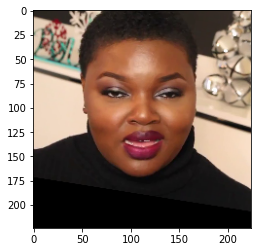

--- 0.21538758277893066 seconds ---


In [20]:
start_time = time.time()
input_dir = '/nas/project_data/B1_Behavior/hakim/FI/frames/train'
mtcnn_output_dir = '/nas/project_data/B1_Behavior/hakim/FI/mtcnn'
output_dir = '/nas/project_data/B1_Behavior/hakim/FI/frames_aligned/train'
annotation_path = '/nas/database/Big5/gt/annotation_training.pkl'

with open(annotation_path, 'rb') as f:
    annotation = pickle.load(f, encoding='latin1')
video_names = list(annotation['extraversion'].keys())

for video_name in video_names:
    print(f'Processing {video_name}')
    dir_name = video_name.rsplit(".")[0] + "." + video_name.rsplit(".")[1]
    in_dir = os.path.join(input_dir, dir_name)
    out_dir = os.path.join(output_dir, dir_name)
    os.makedirs(out_dir, exist_ok=True)
    mtcnn_output_file = mtcnn_output_dir + "/" + dir_name + ".pickle"
    mtcnn_output = pickle.load(open(mtcnn_output_file, "rb"))
        
    for i, landmark in enumerate(mtcnn_output['landmarks']):
        filename = str(i+1) + ".png"
        in_img_path = os.path.join(in_dir, filename)
        out_img_path = os.path.join(out_dir, filename)
        print(out_img_path)

        if (mtcnn_output['landmarks'][i] is None):
            print(f'NO FACE DETECTION - {in_img_path}')
            continue
        else:
            landmark = landmark[0]        
            img = cv2.cvtColor(cv2.imread(in_img_path), cv2.COLOR_BGR2RGB)
            aligned_img = face_alignment(img, landmark)
            img = Image.fromarray(aligned_img)
#                 img.save(out_img_path)

            plt.imshow(aligned_img)
            plt.show()
        break
    break

print("--- %s seconds ---" % (time.time() - start_time))